# Task I - Data Analysis

Please see the report for more detail on considerations made when producing this analysis.

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, FuncFormatter
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np

from load_data import full_data_load
from helper_functions import generate_markdown_table

# Set some styling for charts and visualisations
plt.style.use("ggplot")
colours = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Set directory to save charts to
CHARTS_DIR = "02 Figures"

## Data Load

In [2]:
ff = full_data_load(print_reports=True)
display(ff)

Number of values that exist in both datasests: 325
Number that exists only in Dataset 1 - General: 0
Number that exists only in Dataset 2 - Underwriting: 131

34.0% of records contain zero values

Data loaded.
51 values imputed


,Firm,Metric,Year,Value
0,Firm 1,NWP (£m),2016,-17754.100486
1,Firm 2,NWP (£m),2016,9.244369
2,Firm 3,NWP (£m),2016,0.000000
3,Firm 4,NWP (£m),2016,19677.453353
4,Firm 5,NWP (£m),2016,128.812208
...,...,...,...,...
33515,Firm 452,Gross combined ratio,2020,0.000000
33516,Firm 453,Gross combined ratio,2020,0.000000
33517,Firm 454,Gross combined ratio,2020,0.352309
33518,Firm 455,Gross combined ratio,2020,4.331669


## Firm Size

Create pareto chart of GWP for the report.

There are 325 firms in consideration.


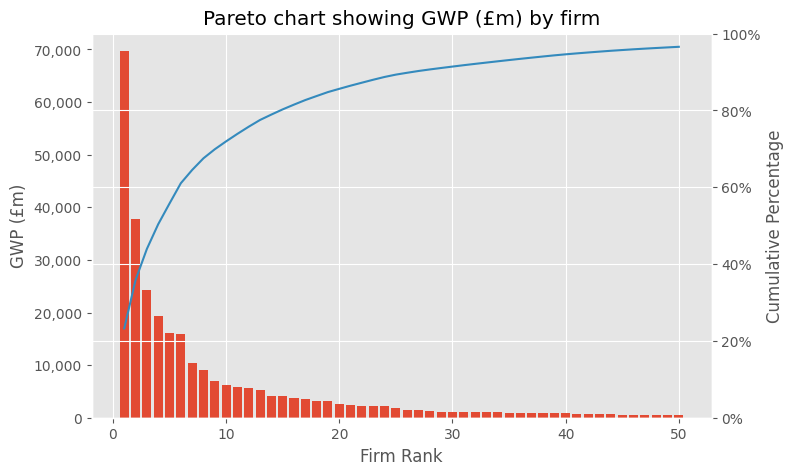

In [4]:
def pareto_chart(metric_name, rank_col, value_col, cumulative_pct_col, max_items=None):
    """
    Generates a Pareto chart.

    Parameters:
        metric_name (str): The name of the metric.
        rank_col (array-like): The ranks of the items.
        value_col (array-like): The values of the items.
        cumulative_pct_col (array-like): The cumulative percentage of the total.
        max_items (int, optional): Maximum number of items to include.

    Returns:
        matplotlib.figure.Figure: The generated figure.
    """

    # Validate the length of inputs
    if len(rank_col) != len(value_col) or len(rank_col) != len(cumulative_pct_col):
        raise ValueError("Input arrays must have the same length.")
    
    # Restrict the inputs to a maximum number of items, if provided
    if max_items is not None:
        mask = rank_col <= max_items
        rank_col = rank_col[mask]
        value_col = value_col[mask]
        cumulative_pct_col = cumulative_pct_col[mask]
    
    # Create subplots
    fig, ax = plt.subplots(figsize=(8, 5))

    # Plot the bar chart for individual values
    ax.bar(rank_col, value_col, color=colours[0])

    # Use FuncFormatter to add thousands separators to left-hand y-axis labels
    ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

    # Create a secondary y-axis for the cumulative percentage line chart
    ax2 = ax.twinx()
    ax2.plot(rank_col, cumulative_pct_col * 100, color=colours[1], marker=None, ms=4)

    # Format the secondary y-axis as percentage, starting from 0
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax2.set_ylim(bottom=0)

    # Set labels and title
    ax.set_xlabel("Firm Rank")
    ax.set_ylabel(metric_name)
    ax2.set_ylabel("Cumulative Percentage")
    plt.title(f"Pareto chart showing {metric_name} by firm")

    # Adjust horizontal grid lines for better readability
    ax.yaxis.grid(False)
    ax2.yaxis.grid(True)

    return fig

def pareto_analysis(ff):
    # Copy the input DataFrame to avoid modifying the original data
    firms = ff.copy()

    # Sort the DataFrame based on the calculated rank
    firms["Rank"] = firms.loc[:, "Value"].rank(ascending=False)
    firms = firms.sort_values("Rank")

    # Calculate the cumulative sum of the "Value" column
    firms["Cumulative Value"] = firms["Value"].cumsum()

    # Calculate the cumulative percentage of the total "Value" column
    firms["Cumulative %"] = firms["Cumulative Value"] / firms["Value"].sum()

    # Return the modified DataFrame with added columns
    return firms

# Choose GWP from 2020
selected_metric = "GWP (£m)"
ff_gwp_2020 = ff[(ff["Metric"] == "GWP (£m)") & (ff["Year"] == 2020)]

# Generate the pareto analysis
firms = ff_gwp_2020.groupby("Metric").apply(pareto_analysis).reset_index(drop=True)

# Generate and save the figure
print(f"There are {firms.shape[0]} firms in consideration.")
fig = pareto_chart(selected_metric, firms["Rank"], firms["Value"], firms["Cumulative %"], max_items=50)
fig.savefig(f"{CHARTS_DIR}/gwp_pareto.png")
plt.show()

In [5]:
# Select a subset of the columns to output
firms_extract = firms[["Rank", "Firm", "Value", "Cumulative %"]]

# Rename the Value column
firms_extract = firms_extract.rename(columns={
    "Value": "GWP 2020 (£m)"
})

# Format the values in the table for presentation
firms_extract["Rank"] = firms_extract["Rank"].map(lambda x: "{:,.0f}".format(x))
firms_extract["Cumulative %"] = firms_extract["Cumulative %"].map(lambda x: "{:.1%}".format(x))
firms_extract["GWP 2020 (£m)"] = firms_extract["GWP 2020 (£m)"].map(lambda x: "{:,.0f}".format(x))

# Generate a table to put in the report
gwp_pareto_table = firms_extract.head(15)
display(gwp_pareto_table)
generate_markdown_table(gwp_pareto_table, f"{CHARTS_DIR}/gwp_pareto.md")

,Rank,Firm,GWP 2020 (£m),Cumulative %
0,1,Firm 210,"69,698",23.3%
1,2,Firm 4,"37,762",35.9%
2,3,Firm 311,"24,251",43.9%
3,4,Firm 34,"19,275",50.4%
4,5,Firm 7,"16,184",55.8%
5,6,Firm 151,"15,825",61.1%
6,7,Firm 26,"10,352",64.5%
7,8,Firm 247,"9,115",67.6%
8,9,Firm 25,"7,032",69.9%
9,10,Firm 73,"6,174",72.0%


Markdown table has been generated and saved to 02 Figures/gwp_pareto.md.


## Changing business profile

Create year-on-year NCR analysis for the report.

Filtering out 217 firms from NCR analysis


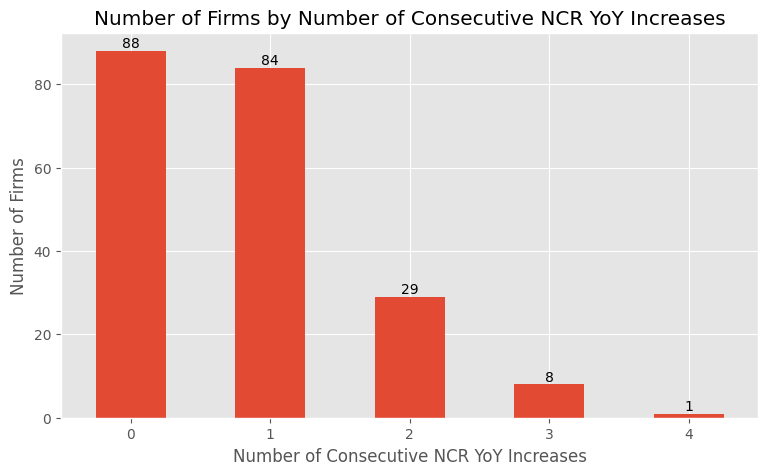

In [6]:
def plot_ncr_analysis(ncr_analysis):
    """
    Plot a bar chart representing the number of firms based on the consecutive NCR YoY increases.

    Parameters:
    - ncr_analysis (pd.DataFrame): DataFrame containing the "Number of Consecutive NCR YoY Increases" column.

    Returns:
    - None
    """
    # Create a bar plot
    fig, ax = plt.subplots(figsize=(9, 5))
    bar_plot = ncr_analysis["Number of Consecutive NCR YoY Increases"].value_counts().sort_index().plot(kind="bar", ax=ax)

    # Set labels and title
    ax.set_xlabel("Number of Consecutive NCR YoY Increases")
    ax.set_ylabel("Number of Firms")
    plt.title("Number of Firms by Number of Consecutive NCR YoY Increases")

    # Rotate x-axis labels
    plt.xticks(rotation=0)

    # Add data labels
    for i, v in enumerate(bar_plot.patches):
        ax.text(v.get_x() + v.get_width() / 2, v.get_height() + 0.1, str(int(v.get_height())), ha='center', va='bottom')

    return fig

# Filter rows in the DataFrame where the "Metric" column is "Net combined ratio"
ncr_ff = ff.loc[ff["Metric"] == "Net combined ratio"]

# Exclude rows corresponding to the firms with zero Net Combined Ratio in 2020
filter_out_firms = ncr_ff[(ncr_ff["Year"] == 2020) & (ncr_ff["Value"] == 0)]["Firm"].unique()
print(f"Filtering out {len(filter_out_firms)} firms from NCR analysis")
ncr_ff = ncr_ff[~ncr_ff["Firm"].isin(filter_out_firms)]
remove_error_firms = ncr_ff[(ncr_ff["Value"] > 10) | (ncr_ff["Value"] < 0)]["Firm"].unique()
ncr_ff = ncr_ff[~ncr_ff["Firm"].isin(remove_error_firms)]

# Calculate the YoY percentage change for each firm and metric
ncr_ff = ncr_ff.sort_values(["Firm", "Metric", "Year"])
ncr_ff["% Change"] = ncr_ff.groupby(["Firm", "Metric"])["Value"].pct_change()

# Sort the DataFrame again, this time in descending order of "Year" for each firm and metric
ncr_ff = ncr_ff.sort_values(["Firm", "Metric", "Year"], ascending=[True, True, False])

# Function to calculate consecutive positive years
def consecutive_positive_years(group):
    count = 0
    for value in group['% Change']:
        if value is not None and value > 0:
            count += 1
        else:
            break
    return count

# Apply the function to each firm's group
ncr_analysis = ncr_ff.groupby("Firm").apply(consecutive_positive_years).rename("Number of Consecutive NCR YoY Increases").reset_index()

# Generate and save the figure
fig = plot_ncr_analysis(ncr_analysis)
fig.savefig(f"{CHARTS_DIR}/ncr_bar.png")
plt.show()

In [7]:
# Filter the NCR analysis to risky firms
filtered_ncr_analysis = ncr_analysis[ncr_analysis["Number of Consecutive NCR YoY Increases"] >= 2]

# Get the historical NCR data for each firm in a table
historical_ncr = ncr_ff.pivot(columns="Year", index="Firm", values="Value")
historical_ncr = historical_ncr.sort_index(axis=1, ascending=True)
historical_ncr = historical_ncr.add_prefix("NCR ")

# Merge the NCR analysis with the historical data
filtered_ncr_analysis = filtered_ncr_analysis.merge(historical_ncr, left_on="Firm", right_index=True)
filtered_ncr_analysis = filtered_ncr_analysis.sort_values(
    ["Number of Consecutive NCR YoY Increases", "NCR 2020"],
    ascending=[False, False]
)

# Format the NCR columns for output
export_ncr_analysis = filtered_ncr_analysis.copy()
export_ncr_analysis.loc[:, "NCR 2016":"NCR 2020"] = export_ncr_analysis.loc[:, "NCR 2016":"NCR 2020"].map(lambda x: "{:.1%}".format(x)).replace("nan%", "")

# Export the chart
display(export_ncr_analysis)
generate_markdown_table(export_ncr_analysis.head(15), f"{CHARTS_DIR}/ncr_analysis.md")

,Firm,Number of Consecutive NCR YoY Increases,NCR 2016,NCR 2017,NCR 2018,NCR 2019,NCR 2020
40,Firm 19,4,30.8%,144.8%,166.3%,173.3%,185.2%
151,Firm 394,3,0.0%,0.0%,56.8%,121.3%,275.1%
106,Firm 311,3,0.0%,0.0%,23.0%,170.5%,189.9%
59,Firm 22,3,177.6%,78.5%,92.8%,162.4%,178.0%
2,Firm 102,3,83.3%,66.0%,129.1%,137.9%,167.8%
123,Firm 344,3,0.0%,0.0%,1.7%,118.4%,145.5%
125,Firm 349,3,52.0%,10.3%,31.3%,136.9%,144.7%
64,Firm 230,3,130.5%,91.2%,119.7%,119.8%,131.4%
46,Firm 198,3,66.6%,50.7%,95.9%,101.0%,118.5%
49,Firm 203,2,108.4%,135.3%,63.8%,123.8%,365.4%


Markdown table has been generated and saved to 02 Figures/ncr_analysis.md.


## Outliers from the norm

Create scatter plot of GCI and SCR coverage ratio highlighting outliers from the norm for the report.

Filtering out 272 firms from outlier analysis


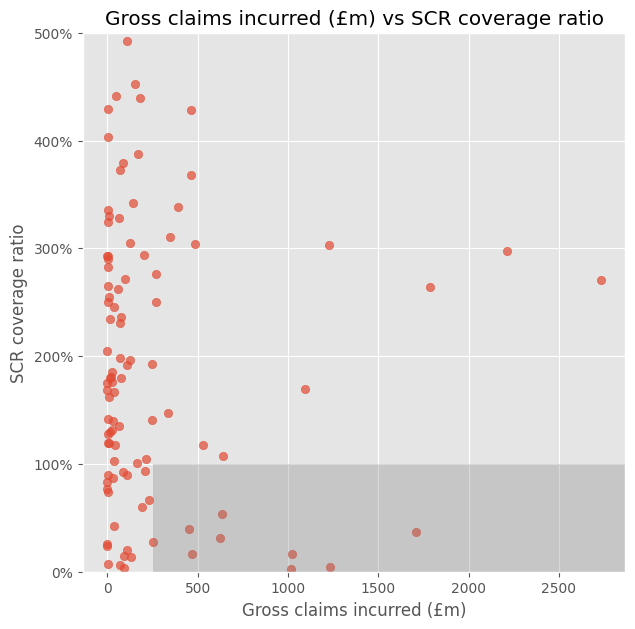

In [8]:
def scr_gci_scatter(gci, scr, gci_max=None, scr_max=None, gci_shade_min=250, scr_shade_max=100):
    """
    Create a scatter plot comparing Gross Claims Incurred (GCI) and SCR coverage ratio.

    Parameters:
    - gci (array-like): Array of values representing Gross Claims Incurred (£m).
    - scr (array-like): Array of values representing SCR coverage ratio.
    - gci_max (float, optional): Upper axis limit for Gross Claims Incurred.
    - scr_max (float, optional): Upper axis limit for SCR Coverage Ratio.
    - gci_shade_min (float, optional): Minimum Gross Claims Incurred value to start the shaded region at.
    - scr_shade_max (float, optional): Maximum SCR Coverage Ratio value to end the shaded region at.
    
    Returns:
    - matplotlib.figure.Figure: The generated scatter plot figure.
    """

    # Validate the length of inputs
    if len(scr) != len(gci):
        raise ValueError("Input arrays must have the same length.")
    
    # Create subplots
    fig, ax = plt.subplots(figsize=(7, 7))

    # Plot the scatter chart
    ax.scatter(x=gci, y=scr, alpha=0.7)

    # Format the secondary y-axis as percentage, starting from 0
    ax.yaxis.set_major_formatter(PercentFormatter())
    ax.set_ylim(bottom=0)

    # Set axis limits, if requested
    if gci_max is not None:
        ax.set_xlim(top=gci_max)

    if scr_max is not None:
        ax.set_ylim(top=scr_max)

    # Set labels and title
    ax.set_xlabel("Gross claims incurred (£m)")
    ax.set_ylabel("SCR coverage ratio")
    plt.title("Gross claims incurred (£m) vs SCR coverage ratio")

    # Add shaded rectangle
    xmin, xmax = gci_shade_min, ax.get_xlim()[1]
    rect = Rectangle((xmin, 0), xmax - xmin, scr_shade_max, linewidth=0, edgecolor='none', facecolor='gray', alpha=0.3)
    ax.add_patch(rect)

    return fig

# Select GCI and SCR coverage ratio from the data
outliers_metrics = ["Gross claims incurred (£m)", "SCR coverage ratio"]
ff_outliers = ff.loc[ff["Metric"].isin(outliers_metrics)]

# Focus on 2020 data only
ff_outliers = ff_outliers[ff_outliers["Year"] == 2020]

# Remove any firms with zero (or less than zero) values
firms_with_zero = ff_outliers[ff_outliers["Value"] <= 0]["Firm"].unique()
print(f"Filtering out {len(firms_with_zero)} firms from outlier analysis")
ff_outliers = ff_outliers[~ff_outliers["Firm"].isin(firms_with_zero)]

# Pivot table for visualisation
firms = ff_outliers.pivot(columns="Metric", index="Firm", values="Value")

# Save a copy to create a table with later
firms_export = firms.copy()

# firms = firms[(firms["SCR coverage ratio"] > 0) & (firms["SCR coverage ratio"] < 100)]

# Generate figure
gci_threshold = 250
scr_threshold = 1
fig = scr_gci_scatter(
    firms["Gross claims incurred (£m)"],
    firms["SCR coverage ratio"] * 100,
    scr_max=500,
    gci_shade_min=gci_threshold, scr_shade_max=scr_threshold * 100
)
fig.savefig(f"{CHARTS_DIR}/scr_gci_scatter.png")
plt.show()

In [9]:
# Select the firms in the shaded region
firms_export = firms_export[
    (firms_export["Gross claims incurred (£m)"] > gci_threshold) & 
    (firms_export["SCR coverage ratio"] > 0) & 
    (firms_export["SCR coverage ratio"] < scr_threshold)
]

# Sort the firms by Gross Claims Incurred
firms_export = firms_export.sort_values("Gross claims incurred (£m)", ascending=False)

# Format the columns for output
firms_export["Gross claims incurred (£m)"] = firms_export["Gross claims incurred (£m)"].map(lambda x: "{:,.0f}".format(x))
firms_export["SCR coverage ratio"] = firms_export["SCR coverage ratio"].map(lambda x: "{:.1%}".format(x))

# Export the table
firms_export = firms_export.reset_index()
display(firms_export)
generate_markdown_table(firms_export, f"{CHARTS_DIR}/scr_gci_table.md")

Metric,Firm,Gross claims incurred (£m),SCR coverage ratio
0,Firm 286,"1,711",37.3%
1,Firm 234,"1,232",4.7%
2,Firm 210,"1,024",16.4%
3,Firm 297,"1,014",2.3%
4,Firm 165,634,53.6%
5,Firm 26,625,31.0%
6,Firm 118,470,16.8%
7,Firm 230,452,39.7%
8,Firm 227,253,27.7%


Markdown table has been generated and saved to 02 Figures/scr_gci_table.md.
